In [1]:
import os, sys, glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

cwd = '/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC'

In [12]:
states = pd.read_csv(os.path.join(cwd,'month_analysis', 'surrogate_input2.csv'), header=None, index_col=0)

In [13]:
states.index = pd.to_datetime(states.index)

In [ ]:
states

In [15]:
states.dropna(axis=0, inplace=True)

In [38]:
# prompt: get the index numbers from a datetime range of "2017-06-01" to "2017-06-16" from states dataframe

start_date = '2017-06-01 0:00'
end_date = '2017-06-16 23:00'

mask = (states.index >= start_date) & (states.index <= end_date)

mask1 = np.where(mask)[0]


start_date = '2017-06-24 0:00'
end_date = '2017-06-30 23:00'

mask = (states.index >= start_date) & (states.index <= end_date)

mask2 = np.where(mask)[0]

training_indices = np.concatenate((mask1, mask2))

In [40]:
start_date = '2017-06-17 0:00'
end_date = '2017-06-23 23:00'

mask = (states.index >= start_date) & (states.index <= end_date)

test_indices = np.where(mask)[0]

In [99]:
X = np.array(states.iloc[:,:-1])

In [100]:
y = np.array(states.iloc[:,-1])

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
X_train = X[training_indices]
X_test = X[test_indices]
y_train = y[training_indices]
y_test = y[test_indices]

#LightGBM

In [79]:
import lightgbm as lgb

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform,randint

In [81]:
param_dist = {
    'estimator__n_estimators': randint(50, 500),
    'estimator__max_depth': randint(2, 15),
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'estimator__num_leaves': randint(5, 30),
}

In [102]:
# Initialize an empty dictionary to store the best hyperparameters and their values
best_hyperparameters = {}
best_values = {}

# Initialize the LightGBM classifier
lgm_regressor = lgb.LGBMRegressor(verbose=-1)
scores = {
          "R2": 'r2',
          "MAPE": 'neg_mean_absolute_percentage_error',
          "MSE": 'neg_mean_squared_error'}
n_iter_search = 250  # Number of parameter settings that are sampled
random_search = RandomizedSearchCV(
    lgm_regressor, param_distributions=param_dist, n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error'
)

# Fit the model to the training data to search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best hyperparameters and their values
best_params = random_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
best_model = random_search.best_estimator_

In [103]:
best_model = random_search.best_estimator_

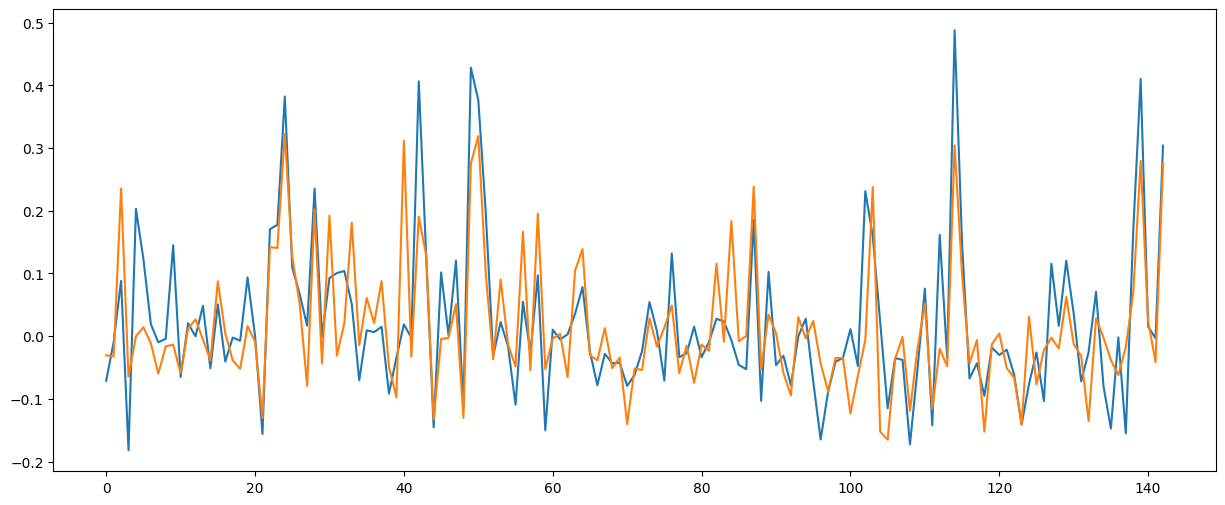

In [104]:
plt.figure(figsize=(15, 6))
plt.plot(y_test)
plt.plot(best_model.predict(X_test))

In [105]:
np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))

0.07974870875085688

In [106]:
np.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))

0.017232898892550273

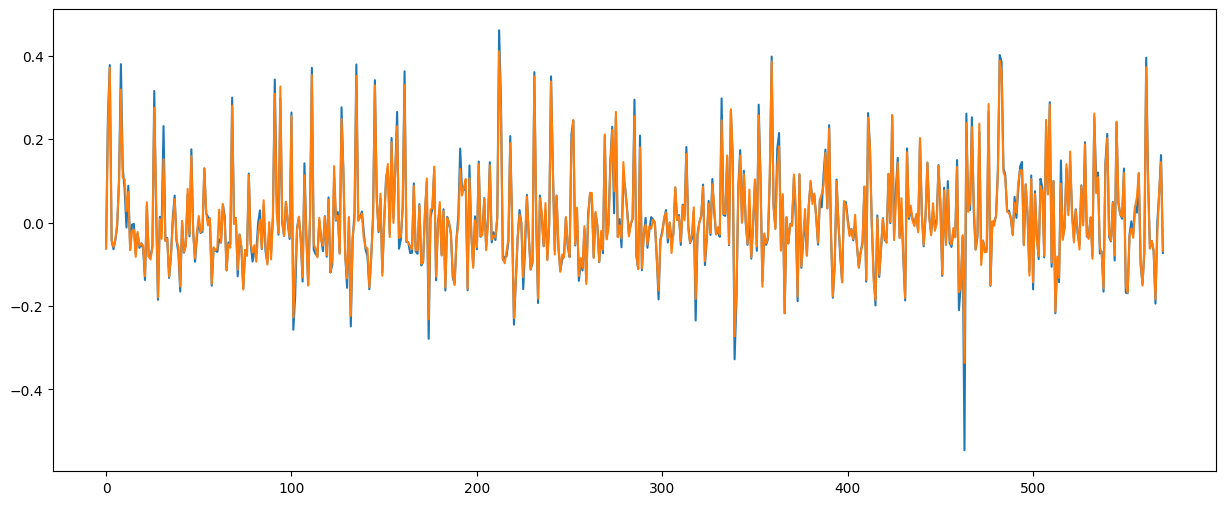

In [107]:
plt.figure(figsize=(15, 6))
plt.plot(y_train)
plt.plot(best_model.predict(X_train))

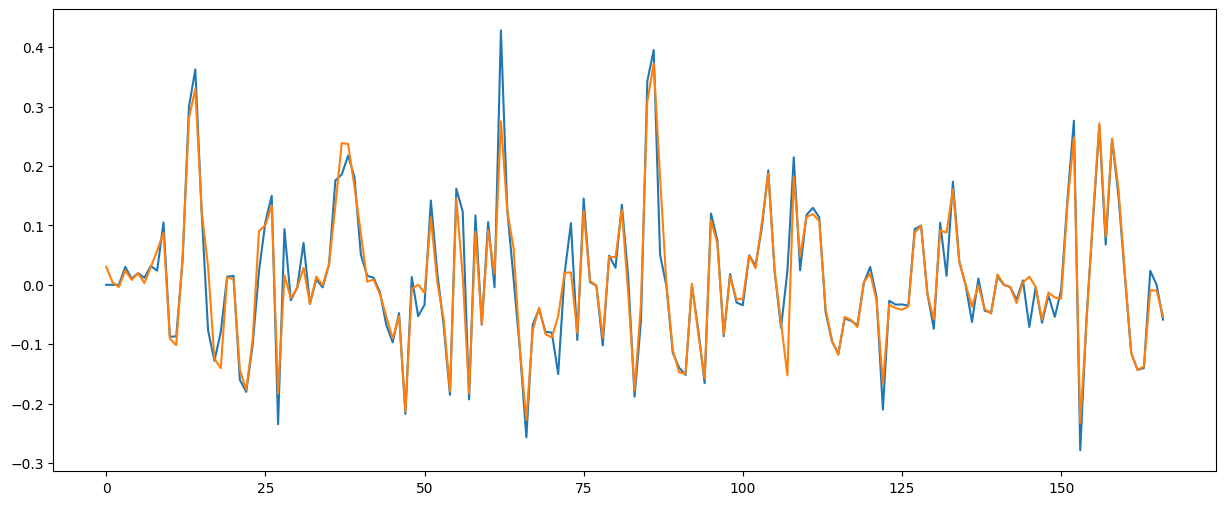

In [108]:
plt.figure(figsize=(15,6))
p=380
d=167
plt.plot(y[p:p+d])
plt.plot(best_model.predict(X[p:p+d]))

In [109]:
import joblib

# save
# joblib.dump(best_model, "gbm_surrogate.pkl")
joblib.dump(best_model, "gbm_surrogate_split.pkl")
# joblib.dump(best_model, "gbm_surrogate_all.pkl")

['gbm_surrogate_split.pkl']

# DNN

In [ ]:
!pip install keras-tuner

In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(cwd,"scaler.pkl"))

['/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/scaler.pkl']

In [ ]:
sys.path.append(os.path.join("/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC"))
from tuner import DNN

In [ ]:
dnn = DNN(97, 1)
dnn.tune_model(X_train, y_train, 200)

Trial 200 Complete [00h 02m 22s]
val_loss: 0.07266896963119507

Best val_loss So Far: 0.018048135563731194
Total elapsed time: 05h 17m 07s


In [ ]:
dnn.tuner.get_best_hyperparameters()[0].values

{'DNN layers': 2,
 'Batch normalization': True,
 'units 1': 256,
 'dropout 1': 0.1,
 'units 2': 16,
 'dropout 2': 0.1,
 'units 3': 16,
 'dropout 3': 0.1,
 'units 4': 256,
 'dropout 4': 0.8,
 'units 5': 256,
 'dropout 5': 0.1,
 'units 6': 256,
 'dropout 6': 0.8}

In [ ]:
dnn.fit(X_train, y_train, 3000)

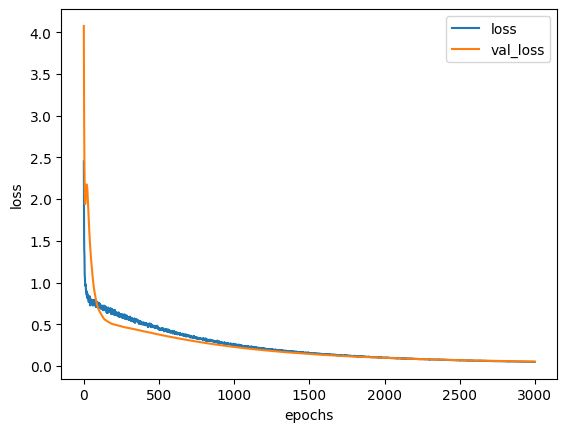

In [ ]:
dnn.visualize()

In [ ]:
np.sqrt(mean_squared_error(y_test, dnn.predict(X_test)))

5/5 [==============================] - 0s 3ms/step


0.11722242506350579

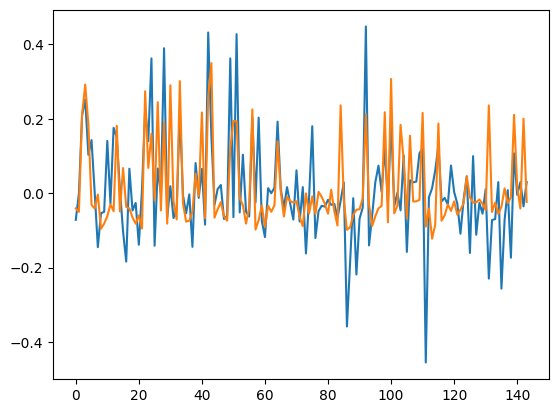

In [ ]:
p=50

plt.plot(y_test)
plt.plot(best_model.predict(X_test))

In [ ]:
dnn.save(cwd, "surrogate")

# CNN

In [61]:
X.shape

(714, 97)

In [62]:
X_ex = np.concatenate((X[:,:96], np.repeat(X[:,96].reshape(-1,1), 24, axis=1)), axis=1)

In [63]:
X_train_ex = X_ex[training_indices]
X_test_ex = X_ex[test_indices]

In [64]:
import joblib
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_ex = scaler.fit_transform(X_train_ex)
X_test_ex = scaler.transform(X_test_ex)
joblib.dump(scaler, os.path.join(cwd,"scaler1D.pkl"))

['/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/scaler1D.pkl']

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Conv1D, Conv1DTranspose, BatchNormalization, UpSampling2D, Reshape, LeakyReLU, Flatten
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

kernel = 3

In [67]:
model = Sequential(
    [
        Input(shape=(X_train_ex.shape[1])),
        Reshape((24, 5)),
        Conv1D(
            filters=16, kernel_size=kernel, padding="same", strides=1, activation="relu"
        ),
        BatchNormalization(),
        Dropout(rate=0.25),
        Conv1D(
            filters=16, kernel_size=kernel, padding="same", strides=1, activation="relu"
        ),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(rate=0.25),
        Dense(1, activation="linear"),
    ]
)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 24, 5)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 16)            256       
                                                                 
 batch_normalization_2 (Bat  (None, 24, 16)            64        
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 24, 16)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 16)            784       
                                                                 
 batch_normalization_3 (Bat  (None, 24, 16)            64        
 chNormalization)                                     

In [68]:
history = model.fit(
    X_train_ex,
    y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=100, mode="min"),
        ModelCheckpoint(filepath = 'CNN1D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True)
    ],
)

Epoch 1/500
14/14 [==============================] - 3s 47ms/step - loss: 1.5791 - val_loss: 0.0388
Epoch 2/500
14/14 [==============================] - 0s 11ms/step - loss: 0.8877 - val_loss: 0.0424
Epoch 3/500
14/14 [==============================] - 0s 10ms/step - loss: 0.7982 - val_loss: 0.0586
Epoch 4/500
14/14 [==============================] - 0s 8ms/step - loss: 0.6990 - val_loss: 0.0486
Epoch 5/500
14/14 [==============================] - 0s 9ms/step - loss: 0.5085 - val_loss: 0.0384
Epoch 6/500
14/14 [==============================] - 0s 8ms/step - loss: 0.5780 - val_loss: 0.0885
Epoch 7/500
14/14 [==============================] - 0s 8ms/step - loss: 0.5317 - val_loss: 0.0816
Epoch 8/500
14/14 [==============================] - 0s 6ms/step - loss: 0.4423 - val_loss: 0.0744
Epoch 9/500
14/14 [==============================] - 0s 9ms/step - loss: 0.3993 - val_loss: 0.0691
Epoch 10/500
14/14 [==============================] - 0s 10ms/step - loss: 0.3999 - val_loss: 0.0540
Epoch

In [70]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test_ex)))

6/6 [==============================] - 0s 6ms/step


0.09394424970617102

18/18 [==============================] - 0s 2ms/step


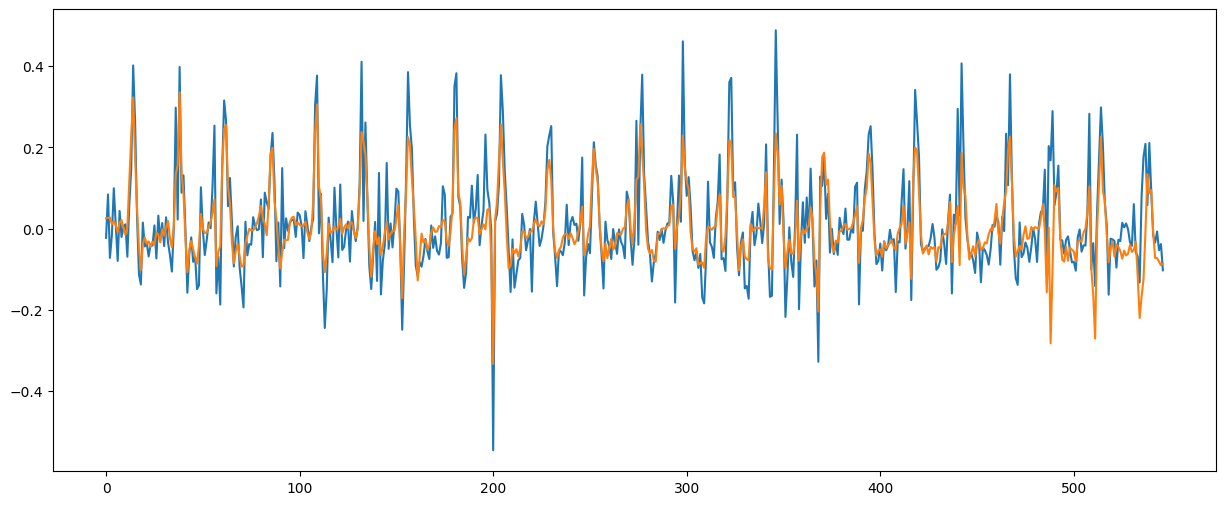

In [72]:
plt.figure(figsize=(15, 6))
plt.plot(y_train)
plt.plot(model.predict(X_train_ex))

6/6 [==============================] - 0s 3ms/step


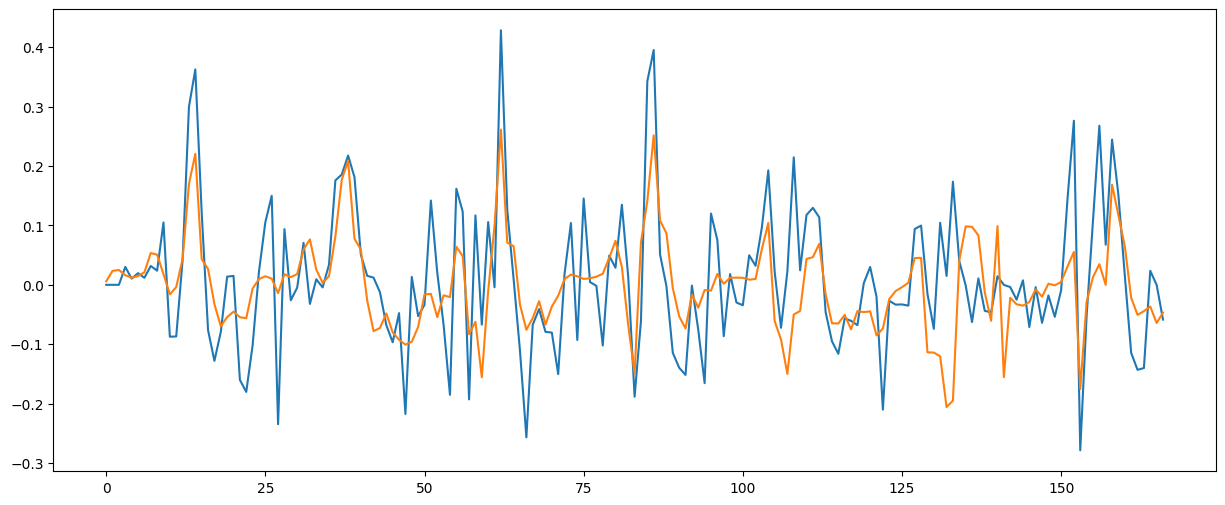

In [73]:
plt.figure(figsize=(15, 6))
plt.plot(y_test)
plt.plot(model.predict(X_test_ex))

6/6 [==============================] - 0s 3ms/step


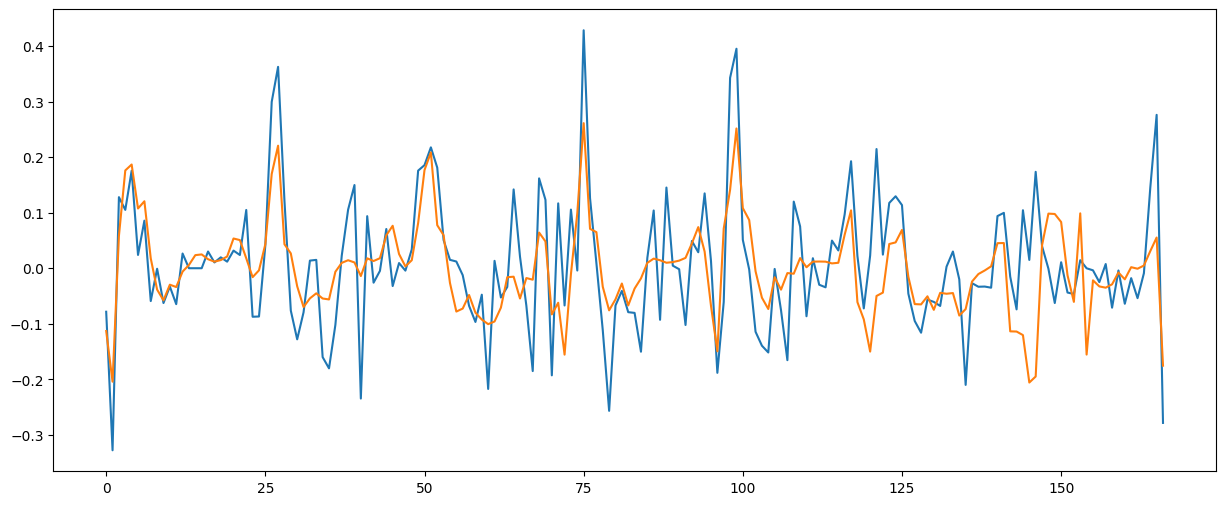

In [74]:
plt.figure(figsize=(15,6))
p=367
d=167
plt.plot(y[p:p+d])
plt.plot(model.predict(scaler.transform(X_ex[p:p+d])))